In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyfits as pyf
import pres_style, os
from PyTools import err, binner, nbins
from scipy.ndimage.filters import gaussian_filter

In [3]:
def put_FITS_names(table):
    descr = table.dtype.descr
    for i in xrange(3): descr.pop(0)
    descr = [("input_file", "|S25")] + descr

    new_table = zeros(table.shape[0], dtype=descr)
    new_table["input_file"] = ["spSpec-{0:05d}-{1:04d}-{2:03d}.fit".format(r["mjd"], r["plate"], r["fiberID"]) for r in table]
    for f in new_table.dtype.names[1:]:
        new_table[f] = table[f]
    
    return new_table

In [19]:
# catalog tables
snr = genfromtxt("data/RealDeal/snr.txt", dtype=None, names=True)
cat = genfromtxt("data/RealDeal/catalog.txt", dtype=None, names=True)
cin = put_FITS_names(genfromtxt("data/RealDeal/conIndex_test.txt", dtype=None, names=True))

# results tables
odir = os.path.expandvars("$master/inputs/real_deal7/outs/spec/")
#table = genfromtxt(odir+"dynbas_output.log", dtype=None, names=True)
table = genfromtxt(odir+"from_gustavo/dynbas_output.log", dtype=None, names=True)

#table = zeros(table1.size+table2.size, dtype=table1.dtype)
#table[:table1.size] = table1
#table[table1.size:] = table2

table["input_file"] = ["spSpec"+name.lstrip("dynbasfit_processed_SPEC_").replace(".log", ".fit") for name in table["input_file"]]

# match tables
in_table = array([galaxy in table["input_file"] for galaxy in snr["input_file"]], dtype=bool)

print "matched all snr in table?", all(snr[in_table]["input_file"]==table["input_file"])
print "matched all cat in table?", all(cat[in_table]["input_file"]==table["input_file"])
print "matched all cin in table?", all(cin[in_table]["input_file"]==table["input_file"])

matched all snr in table? True
matched all cat in table? True
matched all cin in table? True


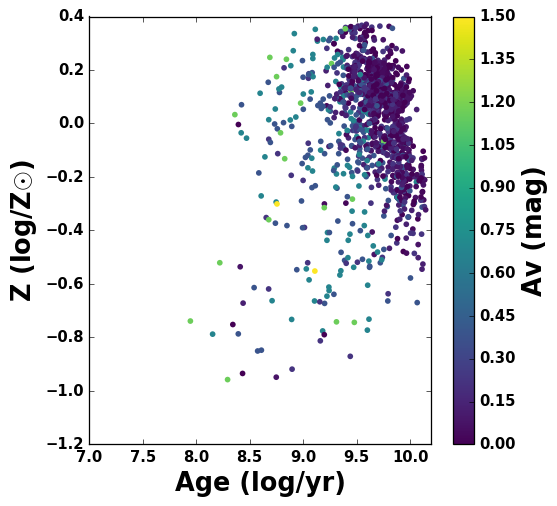

In [20]:
scatter(table["log_t_L_mod"], table["log_Z_L_mod"], c=table["Av_mod"], lw=0, vmin=0.0, vmax=1.5, cmap=cm.viridis)
cb = colorbar()

xlim(7.0, 10.2)
ylim(-1.2, 0.4)

xlabel("Age (log/yr)")
ylabel("Z (log/Z$\odot$)")
cb.set_label("Av (mag)")

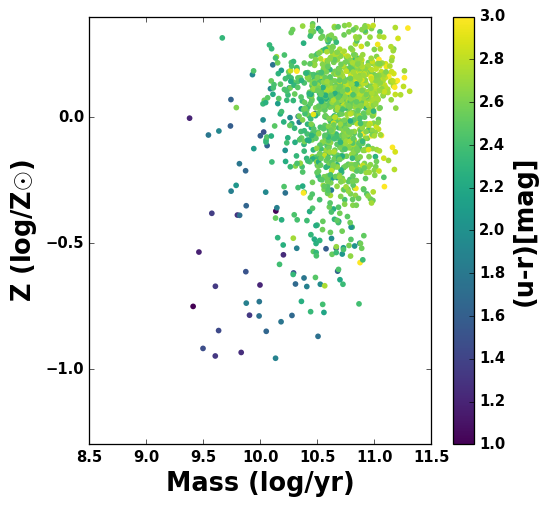

In [21]:
scatter(log10(table["M_mod"]), table["log_Z_L_mod"], c=cat[in_table]["u_mag"]-cat[in_table]["r_mag"], vmin=1.0, vmax=3.0, cmap=cm.viridis)
cb = colorbar()

xlim(8.5, 11.5)
ylim(-1.3, 0.4)

xlabel("Mass (log/yr)")
ylabel("Z (log/Z$\odot$)")
cb.set_label("(u-r)[mag]")

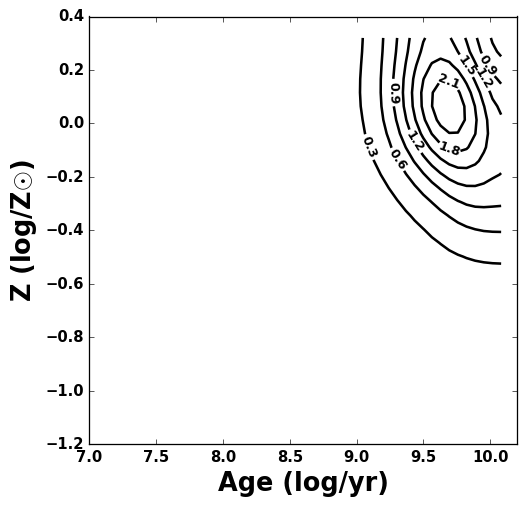

In [22]:
fig, axs = subplots(1, 1)

nx, xi, xf, bsx = nbins(table["log_t_L_mod"])
ny, yi, yf, bsy = nbins(table["log_Z_L_mod"])

H, xe, ye = histogram2d(table["log_t_L_mod"], table["log_Z_L_mod"], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=3)

cont = axs.contour(xe[:- 1], ye[:- 1], H.T, colors="k")
clabel(cont, fontsize=10, fmt=r"%.1f", inline=True)

xlim(7.0, 10.2)
ylim(-1.2, 0.4)

xlabel("Age (log/yr)")
ylabel("Z (log/Z$\odot$)")
cb.set_label("$\chi^2$")

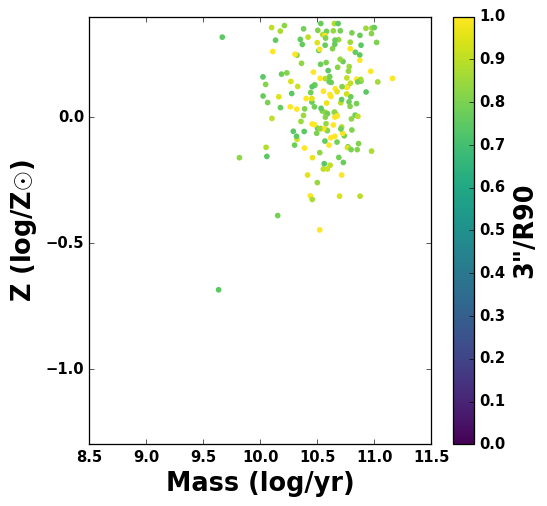

In [23]:
mask_invalid_C = (cin[in_table]["petroR90_r"] > 0.0)

C_index = 3.0/cin[in_table]["petroR90_r"][mask_invalid_C]
CP16 = percentile(C_index, 16)
CP84 = percentile(C_index, 84)
mask_outlayer = C_index>CP84#(C_index>=CP16)&(C_index<=CP84)

scatter(log10(table["M_mod"][mask_invalid_C][mask_outlayer]), table["log_Z_M_mod"][mask_invalid_C][mask_outlayer],
        c=C_index[mask_outlayer], vmin=0.0, vmax=1.0, cmap=cm.viridis)
cb = colorbar()

xlim(8.5, 11.5)
ylim(-1.3, 0.4)

xlabel("Mass (log/yr)")
ylabel("Z (log/Z$\odot$)")
cb.set_label('3"/R90')